# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

---

## Zestaw zadań 2: Badanie intensywności procesów punktowych (część 1)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")
cmap = plt.colormaps["YlOrBr"]

In [3]:
def regular_on_rectangle(grid, random_component, x_lim, y_lim):
    """
    Parameters
    -------
    grid: list
        Lista określająca liczbę punktów w pionie i poziomie.
        Przykład: [10, 10]
    random_component: float
        Liczba z przedziału [0, 1] określająca wielkość komponentu losowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    margx = (x_lim[1] - x_lim[0])/grid[0]/2
    margy = (y_lim[1] - y_lim[0])/grid[1]/2
    xLin = np.linspace(x_lim[0] + margx, x_lim[1] - margx, num = grid[0])
    yLin = np.linspace(y_lim[0] + margy, y_lim[1] - margy, num = grid[1])
    x, y = np.meshgrid(xLin, yLin)
    x = x.flatten() + random_component*np.random.uniform(-margx, margx, grid[0]*grid[1])
    y = y.flatten() + random_component*np.random.uniform(-margy, margy, grid[0]*grid[1])
    return pd.DataFrame({"X" : x, "Y" : y})

def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    n = np.random.poisson(intensity*(x_lim[1]-x_lim[0])*(y_lim[1]-y_lim[0]))
    x = np.random.uniform(x_lim[0], x_lim[1], n)
    y = np.random.uniform(y_lim[0], y_lim[1], n)
    return pd.DataFrame({"X" : x, "Y" : y})

def unhomogeneous_poisson_on_rectangle(intensity_function, x_lim, y_lim):
    """
    Parameters
    -------
    intensity_function: function
        Funkcja przyjmująca dwa argumenty (macierz 1D współrzędnych X i macierz 1D współrzędnych Y) i zwracająca macierz 1D
        z wartościami funkcji opisującej intensywność procesu dla tych współrzędnych.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10] 
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    optRes = sp.optimize.minimize(lambda args: -intensity_function(args), [np.mean(x_lim), np.mean(y_lim)], bounds = (x_lim, y_lim))
    homogeneous_intensity = intensity_function(optRes.x)
    
    df = homogeneous_poisson_on_rectangle(homogeneous_intensity, x_lim, y_lim)
    
    intensity = intensity_function((df["X"], df["Y"]))
    prob = 1 - intensity/homogeneous_intensity
    leave = prob < np.random.rand(len(df))
    return df[leave]

def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    daughter_intensity: float
        Liczba dodatnia określająca intensywność potomnego procesu punktowego.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    a = (x_lim[1]-x_lim[0]+2*cluster_radius)*(y_lim[1]-y_lim[0]+2*cluster_radius)
    n_p = np.random.poisson(parent_intensity * a)
    x = np.random.uniform(x_lim[0]-cluster_radius, x_lim[1]+cluster_radius, n_p)
    y = np.random.uniform(y_lim[0]-cluster_radius, y_lim[1]+cluster_radius, n_p)
    
    a_2 = np.pi*cluster_radius**2;
    X, Y = [], []

    for x, y in zip(x, y):
        n_d = np.random.poisson(daughter_intensity * a_2)
        alpha = 2 * np.pi * np.random.random(n_d)
        r = cluster_radius * np.sqrt(np.random.random(n_d))
        X.extend(r * np.cos(alpha) + x)
        Y.extend(r * np.sin(alpha) + y)
    
    df = pd.DataFrame({"X" : X, "Y" : Y})
    return df[(df["X"] > x_lim[0]) & (df["X"] < x_lim[1]) & (df["Y"] > y_lim[0]) & (df["Y"] < y_lim[1])]

def thomas_on_rectangle(parent_intensity, mean_cluster_size, cluster_sigma, x_lim, y_lim):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    mean_cluster_size: float
        Liczba dodatnia określająca oczekiwaną liczebność generowanych klastrów.
    cluster_sigma: float
        Liczba dodatnia określająca odchylenie standardowe rozkładu wykorzystywanego w procesie generowania klastrów.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    ext = cluster_sigma * 4
    a = (x_lim[1]-x_lim[0]+2*ext)*(y_lim[1]-y_lim[0]+2*ext)
    n = np.random.poisson(parent_intensity * a)
    x = np.random.uniform(x_lim[0]-ext, x_lim[1]+ext, n)
    y = np.random.uniform(y_lim[0]-ext, y_lim[1]+ext, n)

    X, Y = [], []

    for x, y in zip(x, y):
        n_c = np.random.poisson(mean_cluster_size)
        X.extend(np.random.normal(x, cluster_sigma, n_c))
        Y.extend(np.random.normal(y, cluster_sigma, n_c))
    
    df = pd.DataFrame({"X" : X, "Y" : Y})
    return df[(df["X"] > x_lim[0]) & (df["X"] < x_lim[1]) & (df["Y"] > y_lim[0]) & (df["Y"] < y_lim[1])]

### Przygotowanie danych (5 pkt)

Korzystając z funkcji przygotowanych w ramach pierwszego zestawu zadań wygeneruj rozkłady punktowe o podanych paramatrach.

Jednorodny rozkłada Poissona:
 - intensywność procesu: 20
 
Niejednorodny rozkład Poissona:
 - intensywność procesu: f(x, y) = $10(cos(\frac{\pi}{4} x)+1)$

Rozkład Materna:
 - intensywność procesu macierzystego: 0.15
 - intensywność procesu potomnego: 15
 - promień klastra: 1.25
 
Rozkład Thomasa:
 - intensywność procesu macierzystego: 0.3
 - średnia liczebność klastra: 20
 - odchylenie standardowe klastra: 0.75

Parametry identyczne dla wszystkich rozkładów:
 - zakres wartości współrzędnej x: [-10, 10]
 - zakres wartości współrzędnej y: [-5, 5]

In [4]:
df1 = homogeneous_poisson_on_rectangle(20, [-10, 10], [-5, 5])
df2 = unhomogeneous_poisson_on_rectangle(lambda xy: 10*(np.cos(np.pi/4*xy[0])+1), [-10, 10], [-5, 5])
df3 = materna_on_rectangle(0.15, 15, 1.25, [-10, 10], [-5, 5])
df4 = thomas_on_rectangle(0.3, 20, 0.75, [-10, 10], [-5, 5])

### Zadanie 1: Badanie intensywności procesu punktowego metodą szacowania lokalnego (20 pkt)

Przygotuj funkcję `point_count_on_subregions()`, która będzie zliczać punkty w obrębie prostokątnych podobszarów oraz funkcję `intensity_on_subregions()`, która będzie obliczać intensywność procesu punktowego w obrębie prostokątnych podobszarów.

Następnie wykorzystaj przygotowane funkcje do zbadania intensywności wszystkich przygotowanych rozkładów punktów. Ustaw podział obszaru na 40 podobszarów wzdłuż osi $x$ i 20 podobszarów wzdłuż osi $y$.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2).

#### a) Przygotowanie funkcji

In [5]:
def point_count_on_subregions(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    bin_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    hist, x, y = np.histogram2d(points["X"], points["Y"], bins = bins, range = [x_lim, y_lim])
    return [x, y, hist.transpose()]

def intensity_on_subregions(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    intensity_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wartością intensywności przypisaną do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[9, 12], [13, 8]])]
    """
    x, y, hist = point_count_on_subregions(points, bins, x_lim, y_lim)
    a = (x[1]-x[0])*(y[1]-y[0])
    hist /= a
    return [x, y, hist]

#### b) Wygenerowanie danych

In [6]:
x1, y1, hist1 = intensity_on_subregions(df1, [40, 20], [-10, 10], [-5, 5])
x2, y2, hist2 = intensity_on_subregions(df2, [40, 20], [-10, 10], [-5, 5])
x3, y3, hist3 = intensity_on_subregions(df3, [40, 20], [-10, 10], [-5, 5])
x4, y4, hist4 = intensity_on_subregions(df4, [40, 20], [-10, 10], [-5, 5])

#### c) Wizualizacja

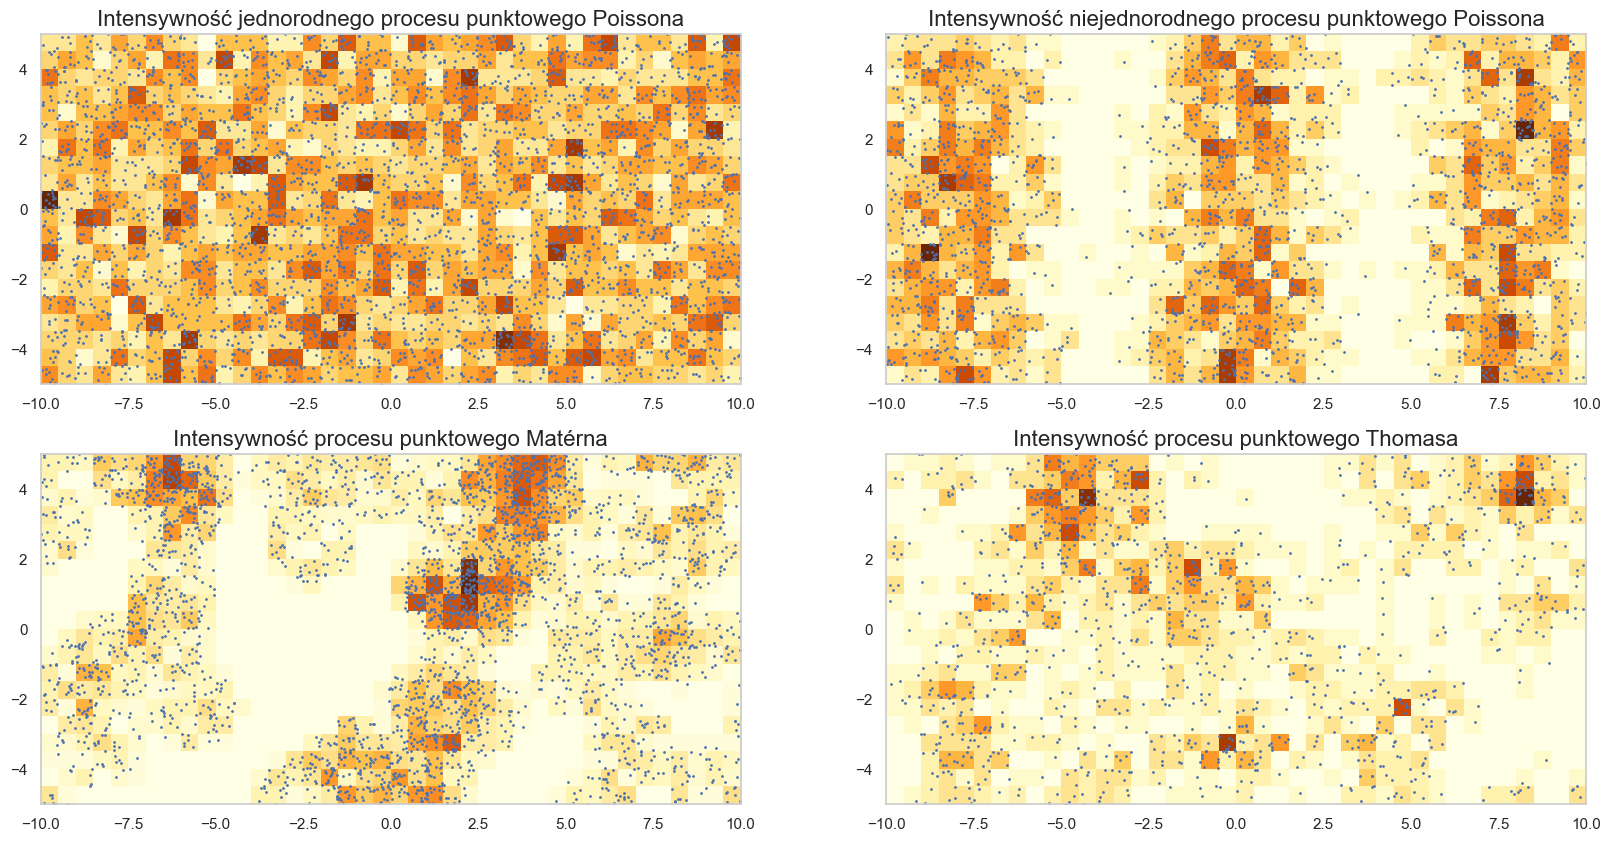

In [7]:
fig, axes = plt.subplots(2, 2, figsize = (20,10))

axes[0,0].pcolormesh(x1, y1, hist1, cmap = cmap)
axes[0,0].set_title("Intensywność jednorodnego procesu punktowego Poissona", fontsize = 16)
axes[0,0].scatter(df1["X"], df1["Y"], s = 1)
axes[0,0].axis('square')
axes[0,0].set_ylim([-5,5])
axes[0,0].set_xlim([-10,10])

axes[0,1].pcolormesh(x2, y2, hist2, cmap = cmap)
axes[0,1].set_title("Intensywność niejednorodnego procesu punktowego Poissona", fontsize = 16)
axes[0,1].scatter(df2["X"], df2["Y"], s = 1)
axes[0,1].axis('square')
axes[0,1].set_ylim([-5,5])
axes[0,1].set_xlim([-10,10])

axes[1,0].pcolormesh(x3, y3, hist3, cmap = cmap)
axes[1,0].set_title("Intensywność procesu punktowego Matérna", fontsize = 16)
axes[1,0].scatter(df3["X"], df3["Y"], s = 1)
axes[1,0].axis('square')
axes[1,0].set_ylim([-5,5])
axes[1,0].set_xlim([-10,10])

axes[1,1].pcolormesh(x4, y4, hist4, cmap = cmap)
axes[1,1].set_title("Intensywność procesu punktowego Thomasa", fontsize = 16)
axes[1,1].scatter(df4["X"], df4["Y"], s = 1)
axes[1,1].axis('square')
axes[1,1].set_ylim([-5,5])
axes[1,1].set_xlim([-10,10])

res = plt.setp(axes, xlim = (-10, 10), ylim = (-5, 5))

### Zadanie 2: Badanie intensywności procesu punktowego metodą funkcji jądrowych (25 pkt)

Przygotuj funkcję `intensity_on_kde()`, która będzie obliczać intensywność procesu punktowego z wykorzystaniem jądrowego estymatora funkcji intensywności danego wzorem:
$$ 	\grave{\lambda}(x,y) = \sum_{d_i < \tau} \frac{3}{\pi \tau^2} (1-\frac{d_i^2}{\tau^2})^2$$ 

gdzie: $d_i$ - odległość punktu od centrum funkcji jądrowej, $\tau$ - promień funkcji jądrowej.

Następnie wykorzystaj przygotowaną funkcje do zbadania intensywności wszystkich przygotowanych rozkładów punktów. Wykonaj obliczania dla promienia funkcji jądrowej równego 1.5 i siatki  200x100 regularnie rozłożonych i pokrywających cały obszar punktów.

Przedstaw wyniki analizy graficznie w postaci wykresów konturowych z wypełnieniem z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2).

Uwaga! Funkcja przygotowana według powyższych wytycznych nie ma wbudowanego mechanizmu korekty na efekt brzegowy, w związu z czym będzie zaniżać wartość intensywności przy krawędziach analizowanego obszaru.

#### a) Przygotowanie funkcji

In [8]:
def intensity_on_kde(points, kernel_radius, grid, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    grid: list
        Lista określająca liczbę punktów w poziomie i pionie, dla których wyliczane będą wartości intensywności.
        Przykład: [10, 10]
    kernel_radius: float
        Liczba dodatnia określająca promień funkcji jądrowej.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    intensity_data: DataFrame
        Tablica zawierająca trzy kolumny - dwie ze współrzędnymi opisane jako "X" i "Y"
        oraz kolumnę z wartościami intensywności wyliczonymi dla tych współrzędnych opisaną jako "I".
    """
    pointsArr = np.array(points)
    gridArr = np.array(regular_on_rectangle(grid, 0, x_lim, y_lim))
    I = []
    r = kernel_radius ** 2
    
    for center in gridArr:
        pts = pointsArr[((center-pointsArr)**2).sum(axis=1) < r]
        s = np.sum((1-(((center-pts)**2).sum(axis=1))**0.5/r)**2)*3/np.pi/r
        I.append(s) 

    gridArr = gridArr.transpose()
    return pd.DataFrame({"X" : gridArr[0], "Y" : gridArr[1], "I" : I})

#### b) Wygenerowanie danych

In [9]:
d1 = intensity_on_kde(df1, 1.5, [200, 100], [-10, 10], [-5, 5])
d2 = intensity_on_kde(df2, 1.5, [200, 100], [-10, 10], [-5, 5])
d3 = intensity_on_kde(df3, 1.5, [200, 100], [-10, 10], [-5, 5])
d4 = intensity_on_kde(df4, 1.5, [200, 100], [-10, 10], [-5, 5])

#### c) Wizualizacja

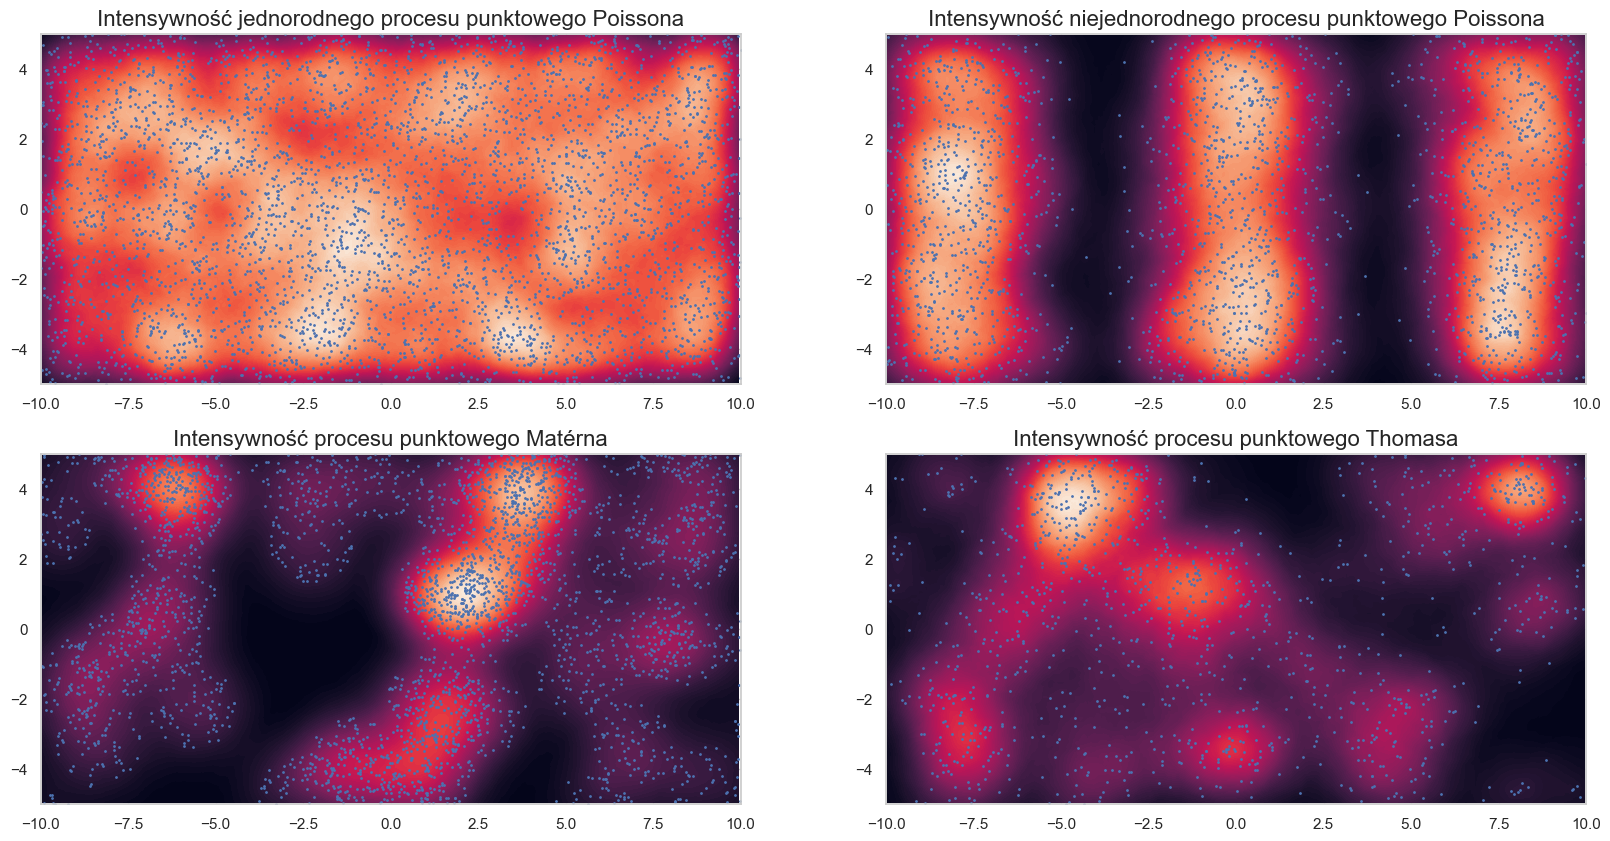

In [10]:
fig, axes = plt.subplots(2, 2, figsize = (20,10))

axes[0,0].tricontourf(mpl.tri.Triangulation(d1["X"], d1["Y"]), d1["I"], levels = 100)
axes[0,0].scatter(df1["X"], df1["Y"], s = 1)
axes[0,0].set_title("Intensywność jednorodnego procesu punktowego Poissona", fontsize = 16)
axes[0,0].axis('square')
axes[0,0].set_ylim([-5,5])
axes[0,0].set_xlim([-10,10])

axes[0,1].tricontourf(mpl.tri.Triangulation(d2["X"], d2["Y"]), d2["I"], levels = 100)
axes[0,1].scatter(df2["X"], df2["Y"], s = 1)
axes[0,1].set_title("Intensywność niejednorodnego procesu punktowego Poissona", fontsize = 16)
axes[0,1].axis('square')
axes[0,1].set_ylim([-5,5])
axes[0,1].set_xlim([-10,10])

axes[1,0].tricontourf(mpl.tri.Triangulation(d3["X"], d3["Y"]), d3["I"], levels = 100)
axes[1,0].scatter(df3["X"], df3["Y"], s = 1)
axes[1,0].set_title("Intensywność procesu punktowego Matérna", fontsize = 16)
axes[1,0].axis('square')
axes[1,0].set_ylim([-5,5])
axes[1,0].set_xlim([-10,10])

axes[1,1].tricontourf(mpl.tri.Triangulation(d4["X"], d4["Y"]), d4["I"], levels = 100)
axes[1,1].scatter(df4["X"], df4["Y"], s = 1)
axes[1,1].set_title("Intensywność procesu punktowego Thomasa", fontsize = 16)
axes[1,1].axis('square')
axes[1,1].set_ylim([-5,5])
axes[1,1].set_xlim([-10,10])

res = plt.setp(axes, xlim = (-10, 10), ylim = (-5, 5))